<font size="8">**Final Report**

# **Introduction**

### What is Diabetes?

Diabetes is a metabolic condition where the body is unable to regulate blood sugar levels effectively (American Diabetes Association, 2013). It is a common disease, with 38.5% of men and 32.8% of women in the US at risk of the condition as reported in a medical study (Gray et al., 2015). There are 2 types of diabetes: Type I and Type II. Type I diabetes is when the body doesn’t produce insulin, a blood sugar-regulating hormone, and is therefore unable to regulate blood sugar levels.  Type I affects around 5-10% of those with diabetes. On the contrary, Type II diabetes is when the body either doesn’t produce enough insulin or doesn’t use it effectively and this accounts for around 90-95% of those with diabetes (American Diabetes Association, 2013). 


### Diagnosing Diabetes & Our Question

The standard for diabetes diagnosis is dictated by ones' blood test results that show Hemoglobin A1c (a component of blood) levels ≥ 6.5 (American Diabetes Association (2013), Patel et al., 2023). Higher blood Glucose levels are also typically shown to be associated with diabetes (American Diabetes Association (2013), Patel et al., 2023). Interestingly, a study conducted on factors associated with diabetes strongly suggest that Body Mass Index (BMI) is associated with diabetes. The results suggested that those with even moderately higher BMI's are associated with an increased risk of developing diabetes (Gray et al., 2015., Patel et al., 2023). Thus, for this project, we aim to answer the question: **Can we predict a patient's diabetes diagnosis based on their blood glucose level (mg/dL) and BMI (kg/m2)?**
    
### Dataset

The dataset we will be using for this project is from Kaggle and contains demographic and laboratory variables on African-American patients including height, weight, gender, age, Hemoglobin A1c level, blood pressure etc. The dataset was initially compiled by Mohamadreza Momeni to use for machine learning models in diabetes diagnosis.

### Biases in Diabetes Literature Review

The motivation for using this dataset is to encourage equity in medical research by using data from a racially diverse sample. A 2023 study by Cronjé et al. has found that the current data and literature on diabetes diagnosis is biased as a large number of diagnosis models are based on data collected largely from non-Hispanic Whites. **This implicates a dangerous overdiagnosis of diabetes among non-Hispanic Whites *and* an underdiagnosis of diabetes among non-Hispanic Blacks** (Cronjé et al., 2023). Thus, our goal for this project is to apply the data analysis skills and knowledge we have gained from DSCI 100 and apply it to this dataset consisting of **only** African-American participants to create a model and further improve inclusion and equity in diabetes literature. 

# **Methods & Results** 
We start     
1) Load Data
2) Clean & Wrangle Data
3) Exploratory Data Analysis
4) Visualize Exploratory Data
5) Data Analysis

>5.1) Upsample uneven data
>
>5.2) Standardize parameters
>
>5.3)  Choose a k

>> a) Create 5 splits

>>b) Create tune k-classification spec

>>c) Find accuracies of each k

>>d) Visualize the accuracy of each k
>
>5.4) Fit classifier with best k found
>
>5.5) Test classifier on testing data

>>Summary of results 
6) Visualize 


Please run the following cell to load the necessary library packages

In [2]:
# Run this cell before continuing
library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("themis")
library(themis)
library(shiny)
install.packages('kknn')
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed

## **1) Load Data**

Our data is loaded from the URL generated through GitHub

In [3]:
#Read data 
URL <- 'https://raw.githubusercontent.com/wmma2/group_18_project/main/diabetes.csv'
diabetes_data <- read_csv(URL)

#Check all the available columns
glimpse(diabetes_data)

Rows: 403 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): location, gender, frame
dbl (16): id, chol, stab.glu, hdl, ratio, glyhb, age, height, weight, bp.1s,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 403
Columns: 19
$ id       <dbl> 1000, 1001, 1002, 1003, 1005, 1008, 1011, 1015, 1016, 1022, 1…
$ chol     <dbl> 203, 165, 228, 78, 249, 248, 195, 227, 177, 263, 242, 215, 23…
$ stab.glu <dbl> 82, 97, 92, 93, 90, 94, 92, 75, 87, 89, 82, 128, 75, 79, 76, …
$ hdl      <dbl> 56, 24, 37, 12, 28, 69, 41, 44, 49, 40, 54, 34, 36, 46, 30, 4…
$ ratio    <dbl> 3.6, 6.9, 6.2, 6.5, 8.9, 3.6, 4.8, 5.2, 3.6, 6.6, 4.5, 6.3, 6…
$ glyhb    <dbl> 4.31, 4.44, 4.64, 4.63, 7.72, 4.81, 4.84, 3.94, 4.84, 5.78, 4…
$ location <chr> "Buckingham", "Buckingham", "Buckingham", "Buckingham", "Buck…
$ age      <dbl> 46, 29, 58, 67, 64, 34, 30, 37, 45, 55, 60, 38, 27, 40, 36, 3…
$ gender   <chr> "female", "female", "female", "male", "male", "male", "male",…
$ height   <dbl> 62, 64, 61, 67, 68, 71, 69, 59, 69, 63, 65, 58, 60, 59, 69, 6…
$ weight   <dbl> 121, 218, 256, 119, 183, 190, 191, 170, 166, 202, 156, 195, 1…
$ frame    <chr> "medium", "large", "large", "large", "medium", "large", "medi…
$ bp.1s    <dbl> 1

# **2) Clean & Wrangle Data**

The dataset is already tidy. 

For our analysis, we will use **blood glucose** and **BMI** to predict **diabetes diagnosis** as higher blood glucose levels and BMI scores have been found to be associated with diabetes in current literature.

Since we already have a column in `diabetes_data` with blood glucose (`stab.glu`), we don't need to do anything there.

But we will need to create 2 new columns: **diagnosis** (our categorical column) and **BMI** (in *kg/m^2*) (one of our predictor variables) since we don't have those yet.

- The **diagnosis** column will use data from the `glyhb` (Glycosylated Hemoglobin) column which corresponds to Hemoglobin A1c levels to indicate whether a person has diabetes or not. Rows that are greater or equal to 6.5 will be 'yes' and rows that are less than 6.5 will be 'no'.

- The **BMI** column will use data from the `weight` and `height` columns. BMI will be calculated using the standard formula (Fehring, 2007): BMI = (`weight` $\times$ 0.45359237) / (`height` $\times$ 0.0254)

Additionally, we can filter out the rows with missing values as they are not significant to our dataset.

Finally, we will select the necessary columns: `BMI`, `diagnosis` and `stab.glu` as we are interested in the whether the factors `stab.glu` (stable blood glucose levels) and `BMI` are related to the diabetes diagnosis.

Our clean and wrangled data will be assigned to a new tibble called `tidy_diabetes`.

In [4]:
tidy_diabetes <- diabetes_data |>

#Create 'diagnosis' column
        mutate(diagnosis = if_else(glyhb >= 6.5, "yes", "no")) |>
        mutate(diagnosis = as_factor(diagnosis))|>

#Create 'BMI' column
        mutate(height_m = height*0.0254, 
               weight_kg = weight*0.45359237,
               BMI = weight_kg/height_m^2) |>

#Filter missing values
        filter(!is.na(glyhb + BMI + stab.glu)) |>

#Select necessary columns
        select(stab.glu, BMI, diagnosis)
               
head(tidy_diabetes)
tail(tidy_diabetes)
nrow(tidy_diabetes)

stab.glu,BMI,diagnosis
<dbl>,<dbl>,<fct>
82,22.13096,no
97,37.41923,no
92,48.37028,no
93,18.63784,no
90,27.82477,yes
94,26.49935,no


stab.glu,BMI,diagnosis
<dbl>,<dbl>,<fct>
85,21.95075,no
90,21.72884,no
369,25.54737,yes
89,27.27960,no
269,24.66134,yes
76,34.89663,no


[1] 384

With the clean and wrangled data above, we can now continue with our data analysis.

# **3) Exploratory Data Analysis**

#### **3.1) Split data into training and testing**

First we split the `tidy_diabetes` dataset into training (`diabetes_train`) and testing (`diabetes_test`) data to make sure that none of our testing data is 'seen' in our classifier. We have chosen to use a 75/25 split meaning 75% of our data will be in the training set and 25% in will be in the testing set as a larger proportion in the training set will give us a more accurate classifier.

We do not need to check for missing values as we have already filtered them out in the previous step. 

In [5]:
set.seed(2023)

diabetes_split <- initial_split(tidy_diabetes, prop = 0.75 , strata = diagnosis)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

#### **3.2) Check for uneven categorical data**

To ensure a robust and unbiased classifier, we need to check that our data has roughly an even amount of 'yes' and 'no' responses in the diagnosis column. We do this by checking the counts of each category in the `diagnosis` column.

In [93]:
train_count <- diabetes_train|>
    group_by(diagnosis)|>
    summarize(count = n()) |>
    ggplot(aes(x = "", y= count, fill = diagnosis)) +
    geom_bar(stat = "identity") + 
    theme(text = element_text(size=10)) +
    labs(y = "Number of patients", x = "Diebetes test", fill = "Diagnosed?") +
    ggtitle("Proportions of diagnosis") +
    scale_fill_brewer(palette = 'YlOrRd') 

options(repr.plot.width = 3, repr.plot.height = 3) 

#### **3.3) Check for distributions of BMI & stab.glu**

Next, we calculate the means of the variables `BMI` and `stab.glu` to check if will need to standardize our data.

In [7]:
train_mean <- diabetes_train|>
    summarize(stab.glu_mean = mean(stab.glu),
              BMI_mean = mean(BMI))

## **Summary of exploratory data analysis**

stab.glu_mean,BMI_mean
<dbl>,<dbl>
105.6376,28.89398


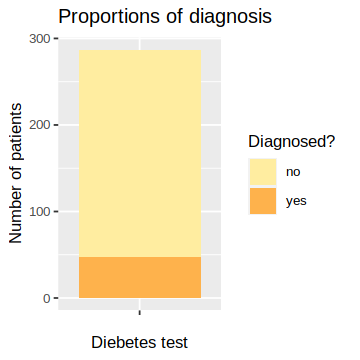

In [94]:
train_count
train_mean

From `train_count`, we see that our data is uneven and therefore needs to be upscaled when training our classifier. 

From `train_mean`, we see that the means stab.glu and BMI vary by quite a bit, thus we will need to standardize the data.

# **4) Visualization**

We will now plot blood glucose levels `stab.glu` and `BMI` to check distribution of our predictors, as well as see if there is any obvious correlation. We will also color code the data points based on their `diagnosis` label to see if any visible patterns or trends emerge.

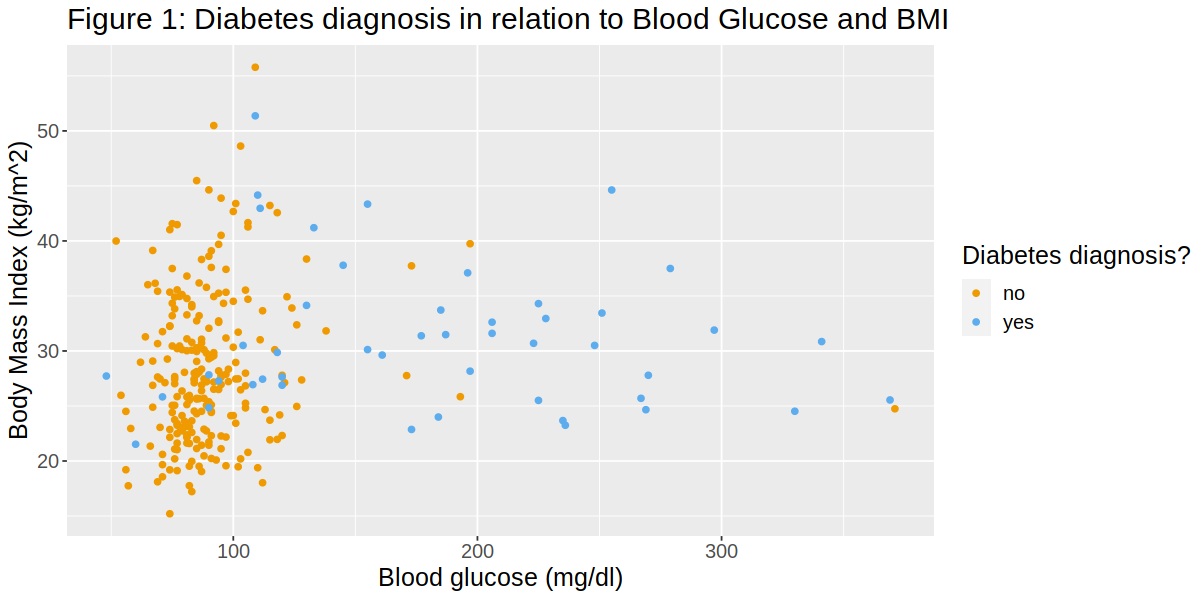

In [89]:
#run this cell 
options(repr.plot.width = 10, repr.plot.height = 5)

train_plot <- diabetes_train |>
    ggplot(aes(x = stab.glu, y = BMI, colour = diagnosis)) +
    geom_point() +
    labs(x = "Blood glucose (mg/dl)", y = "Body Mass Index (kg/m^2)", colour = "Diabetes diagnosis?") +
    ggtitle('Figure 1: Diabetes diagnosis in relation to Blood Glucose and BMI') +
    scale_colour_manual(values = c('orange2', 'steelblue2')) +
    theme(text=element_text(size = 15))
train_plot

From the plot above, we can see that a lower blood glucose level seems to be associated with no diabetes diagnosis. The trend with BMI is harder to tell as both diagnosis labels appear to fall in the same range.

From the visualization, we can also see that the range of blood glucose `stab.glu` is on a much larger scale than `BMI`, meaning it will have a greater effect on our k-NN model. To counter this, we will standardize the predictors in our data analysis.

# **5) Data Analysis**

Since K-nearest neighbors is sensitive to the scale of the predictors, we will complete preprocessing to standardize the predictors (standardizing will center/shift and scale). An important thing to note is that standardization will only be applied to our training set to ensure that our test data does not influence the training of our model. After our preprocessing is complete, we will apply this later on, separately to both our training and testing data sets.

As we have already split the training and testing datasets, we will first upsample the uneven data, then standardize our parameters, and create our K-nearest neighbour classifier with `diabetes_train`.

#### **Use the training data we split in our exploratory data analysis(75% training, 25% testing)**

In [10]:
#We've already split the data above
#Reminder what they look like
#Split and only use the training data from here when creating our classifier

glimpse(diabetes_train)

Rows: 287
Columns: 3
$ stab.glu  <dbl> 97, 94, 75, 87, 89, 82, 75, 76, 78, 81, 97, 65, 66, 87, 74, …
$ BMI       <dbl> 37.41923, 26.49935, 34.33549, 24.51366, 35.78233, 25.95949, …
$ diagnosis <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, …


## **5.1) Upsample uneven data**

In [11]:
set.seed(2023)
#Upsample our training data as there are 287 no's and 97 yes's
#Want to replicate the yes's

#Creating recipe to upsample our data
ups_recipe <- recipe(diagnosis~ BMI + stab.glu, data = diabetes_train) |>
    step_upsample(diagnosis, over_ratio = 1, skip = FALSE) |>
    prep()

#Applying this to our training data 
diabetes_even_train <- bake(ups_recipe, diabetes_train)
                                         
#Check our data is upsampled
check_count<- diabetes_even_train |>
    group_by(diagnosis)|>
    summarize (count = n())
check_count

diagnosis,count
<fct>,<int>
no,240
yes,240


## **5.2) Standardize parameters**

In [12]:
# Standardize the mean and SD of predictors 
diabetes_recipe <- recipe(diagnosis ~BMI + stab.glu, data = diabetes_even_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

## **5.3) Choose a K**

#### **a) Create 5 splits**

In [13]:
set.seed(2023)
diabetes_vfold <- vfold_cv(diabetes_even_train, v = 5, strata = diagnosis)

#### **b) Create knn classification spec**

In [14]:
#Tune K specifications
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### **c) Find accuracies of each K**

In [29]:
#Create tibble with 1-25 K's
k_vals <- tibble(neighbors = seq(from = 15, to = 40))

#Apply this into a workflow
knn_results <- workflow() |>
  add_recipe(diabetes_recipe) |>
  add_model(knn_spec_tune) |>
  tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
  collect_metrics() 

#Gather results from tuned K
accuracies <- knn_results |>
  filter(.metric == "accuracy")
head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.8458333,5,0.006909635,Preprocessor1_Model01
16,accuracy,binary,0.8458333,5,0.006909635,Preprocessor1_Model02
17,accuracy,binary,0.8625000,5,0.012058163,Preprocessor1_Model03
18,accuracy,binary,0.8625000,5,0.012058163,Preprocessor1_Model04
19,accuracy,binary,0.8708333,5,0.014950729,Preprocessor1_Model05
20,accuracy,binary,0.8708333,5,0.014950729,Preprocessor1_Model06


#### **d) Plot Accuracy vs K to visualize best K**

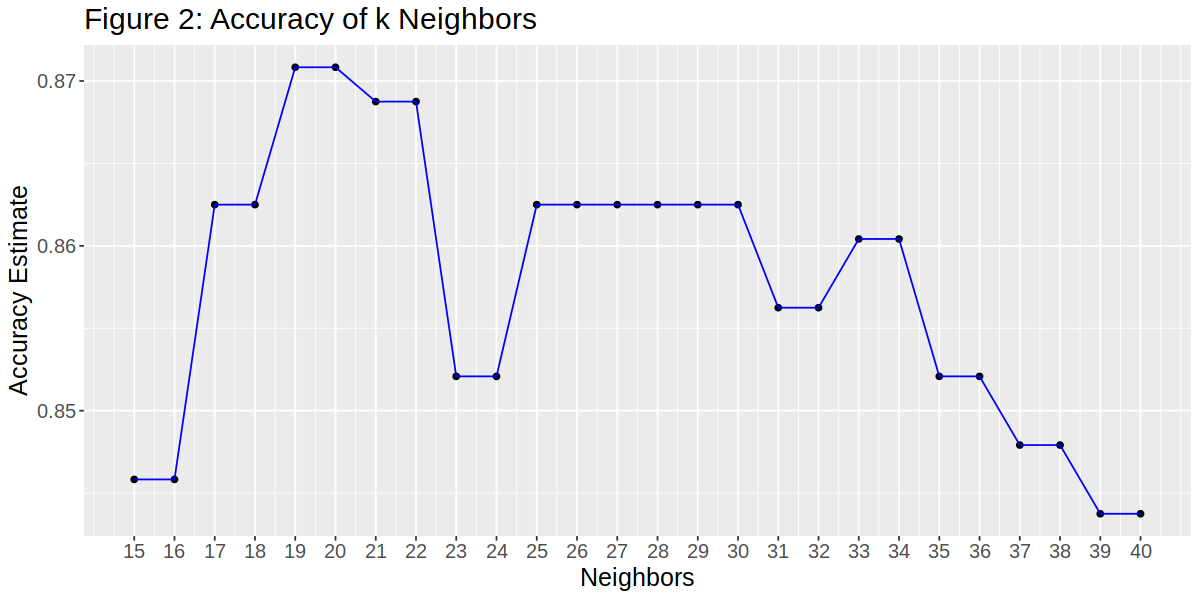

In [37]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = 'blue') +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle('Figure 2: Accuracy of k Neighbors') +
    scale_x_continuous(breaks = seq(15, 40, by = 1)) +
    theme(text = element_text(size = 15))
accuracy_vs_k

## **5.4) Fit classifier with best k found**

Our results from tuning k show us that k = 19 or k = 20 provides the highest accuracy. To avoid ties, we will choose the odd k value, k = 19.

In [95]:
#1) Make spec for k = 19
knn_spec19 <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit19 <- workflow() |>
  add_recipe(diabetes_recipe) |>
  add_model(knn_spec19) |>
  fit(data = diabetes_even_train)
knn_fit19

#2) Predicting test set with k = 19 classifier
diabetes_test_predictions19 <- predict(knn_fit19, diabetes_test) |>
  bind_cols(diabetes_test)

head(diabetes_test_predictions19)

#3) Evaluate results
diabetes_test_accuracy19 <- diabetes_test_predictions19 |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy")

head(diabetes_test_accuracy19)

#4) Confusion matrix
confusion19 <- diabetes_test_predictions19 |>
             conf_mat(truth = diagnosis, estimate = .pred_class)
confusion19

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1541667
Best kernel: rectangular
Best k: 19

.pred_class,stab.glu,BMI,diagnosis
<fct>,<dbl>,<dbl>,<fct>
no,82,22.13096,no
yes,92,48.37028,no
no,93,18.63784,no
no,92,28.20548,no
yes,128,40.75463,no
no,79,33.32562,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8659794


          Truth
Prediction no yes
       no  70   2
       yes 11  14

# **6) Visualizing the Confusion Matrix**

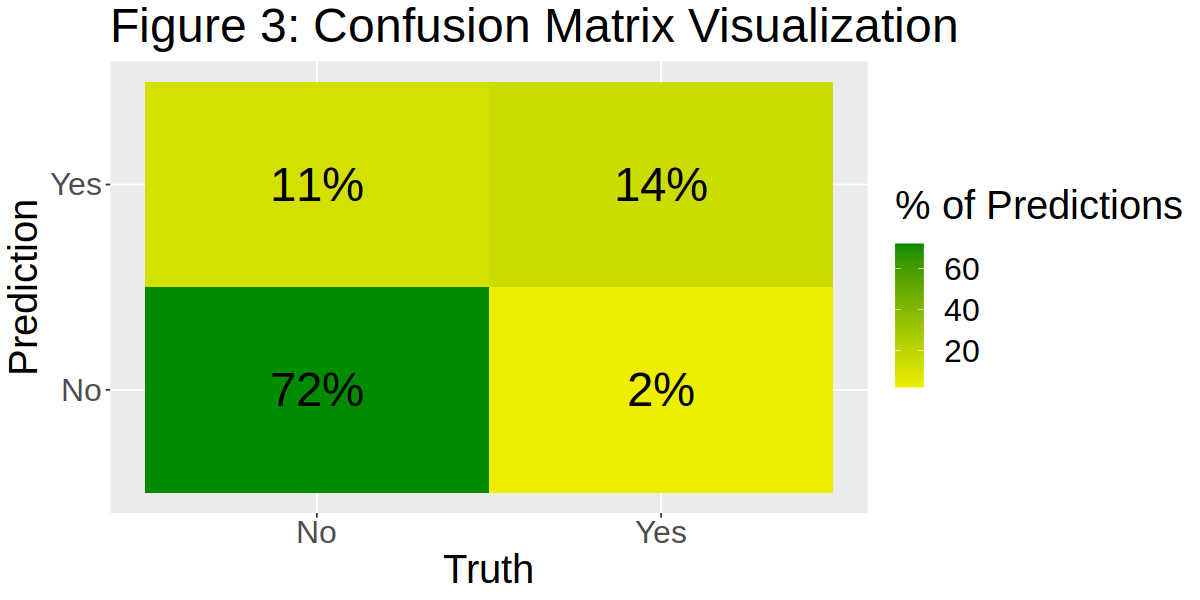

In [94]:
#Visualize the confusion matrix
Prediction <- as.factor(c("Yes", "No", "Yes", "No"))
Truth <- as.factor(c("Yes", "Yes","No", "No"))
outcome <- c((14/97)*100, (2/97) * 100, (11/97) * 100, (70/97) * 100)

conf_mat_data <- tibble(Truth, Prediction, outcome)

ggplot(data = conf_mat_data, mapping = aes(x = Truth, y = Prediction)) +
geom_tile(aes(fill = outcome)) +
scale_fill_gradient(low = "yellow2", high = "green4") +
geom_text(aes(label = str_c(round(outcome), "%")), size = 10) +
ggtitle("Figure 3: Confusion Matrix Visualization") +
labs(fill = "% of Predictions") +
theme(text = element_text(size = 24))

# **Results**

# **Discussion**

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

# **References**

<font size="2">American Diabetes Association. (2013). Diagnosis and Classification of Diabetes Mellitus. *Diabetes Care, 37(1)*, S81–S90. https://doi.org/10.2337/dc14-S081

<font size="2">Cronjé, Héléne T., Katsiferis, Aleandros, Elsenburg, Leonie K., Andersen, Theo O., Rod, Naja H. Varga, Tibor V. (2023). Assessing racial bias in type 2 diabetes risk prediction algorithms. *PLOS Glob Public Health. 2023; 3(5)*, e0001556. https://doi.org/10.1371/journal.pgph.0001556
    
<font size="2">Fehring, Thomas, K., Odum, Susan, M., Griffin, William, L., Mason, Bohannon., McCoy, Thomas H. (2007). The Obesity Epidemic: Its Effect on Total Joint Arthroplasty. *The Journal of Arthroplasty, 22(6)*, 71-76. https://doi.org/10.1016/j.arth.2007.04.014

<font size="2">Gray, Natallia., Picone, Gabriel., Sloan, Frank., Yashkin, Arseniy. (2015). The Relationship between BMI and Onset of Diabetes Mellitus and its Complications. *National Library of Medicine, 108(1), 29-36*. https://doi: 10.14423/SMJ.0000000000000214

<font size="2">Momeni, Mohamadreza. (2023). Diabetes. Version 1 . Retrieved Oct 24, 2023 from https://www.kaggle.com/datasets/imtkaggleteam/diabetes 

<font size="2">Patel, B. J., Mehta, D. N., Vaghani, A., & Patel, K. (2023). Correlation of Body Mass Index (BMI) with Saliva and Blood Glucose Levels in Diabetic and Non-Diabetic Patients. *Journal of pharmacy & bioallied sciences, 15(Suppl 2)*, S1204–S1207. https://doi.org/10.4103/jpbs.jpbs_159_23
